# 5.4 컨브넷 학습 시각화

- Convnet은 시각적인 개념을 학습한 것이기에 시각화하기 아주 좋음
- 따라서 딥러닝에서 말하는 블랙박스라는 개념은 Convnet에는 해당되지 않음

### Convnet의 유용한 시각화 기법 3가지
1. 중간층의 출력(활성화)을 시각화하기
   - 연속된 Convnet 층이 입력을 어떻게 변형시키는지 이해할 수 있음
   

2. 필터를 시각화하기
    - 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 이해할 수 있음
    
    
3. 클래스 활성화에 대한 heatmap을 이미지에 시각화
    - 이미지의 어느 부분이 classification에 기여했는지 이해
    - 이미지에서 객체의 위치를 추정(localization)하는데 도움

## 5.4.1 중간층의 출력(활성화) 시각화하기

### 중간층의 출력(활성화) 시각화
- 어떤 입력이 주어졌을 때 합성곱과 풀링층이 출력하는 **feature map을 그리는 것**
- 층의 출력이 활성화 함수의 출력이라서 활성화(activation)라고도 부름
- 각 채널별로 독립적인 특성을 인코딩하므로 **채널별로 2D 이미지로 시각화** 하는것이 좋은 방법
    - (width, height, ***channel(depth)***)

In [1]:
# 5.2절에서 학습시킨 모델 이용

from keras.models import load_model

model = load_model('./datasets/cats_and_dogs/small/saved_models/cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

(1, 150, 150, 3)


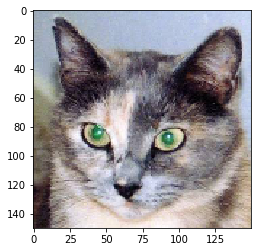

In [2]:
# 입력에 사용할 사진 가져오기

img_path = './datasets/cats_and_dogs/small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)

# reshape로 아래와 같이 할 수도 있음
# img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

### Sequential API와 Functional API

- Sequential API
    - layer-by-layer
    - 여러 입력, 출력 모델을 만드는데 제한이 있음
    
    
- Functional API (7장에서 더 자세히 다룸)
    - 모델은 만드는데 더욱 유연함
    - 여러 입력, 출력 모델을 만들 수 있음

In [3]:
# Functional API를 사용해 합성곱 기반 층 모두를 출력하는 모델 만들기

from keras import models

# 상위 8개 층 : 합성곱 기반 층 (Conv + Pooling)
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input,
                                outputs=layer_outputs)

activation_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0   

In [4]:
# 전체 출력(활성화)
activations = activation_model.predict(img_tensor)
print("전체 출력(활성화) 수 :", len(activations))

# 첫번째 feature map
first_layer_activation = activations[0]
print("첫번째 feature map 텐서 :", first_layer_activation.shape)

전체 출력(활성화) 수 : 8
첫번째 feature map 텐서 : (1, 148, 148, 32)


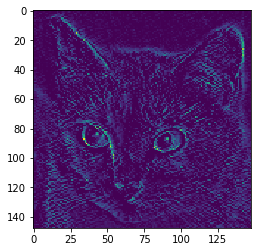

In [5]:
import matplotlib.pyplot as plt

# 첫번째 feature map의 20번째 채널 가시화
plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')

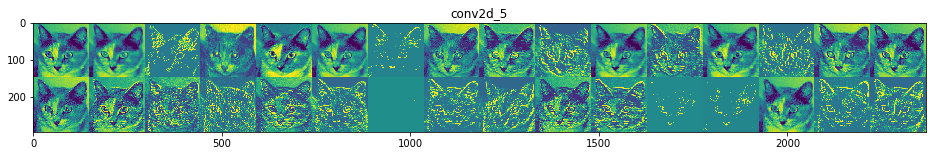

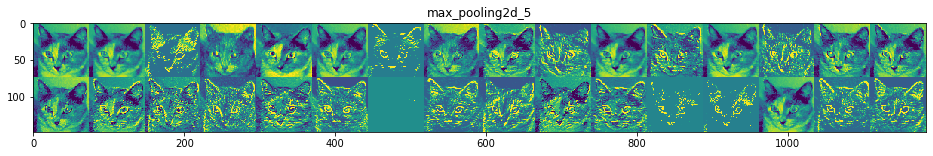

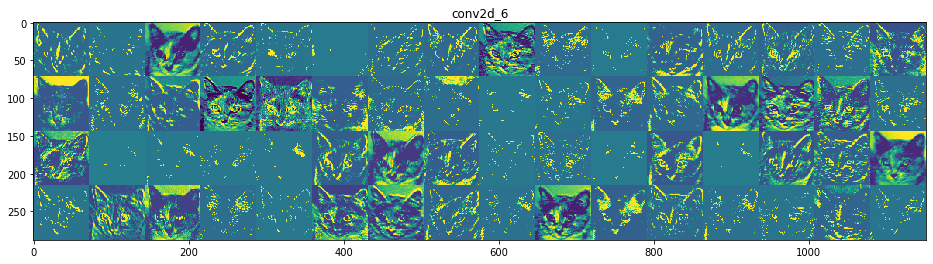

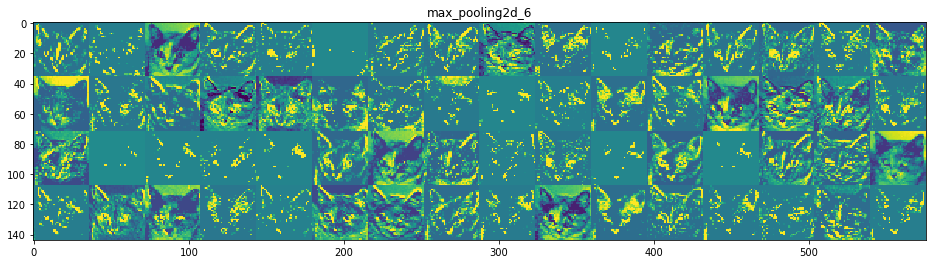

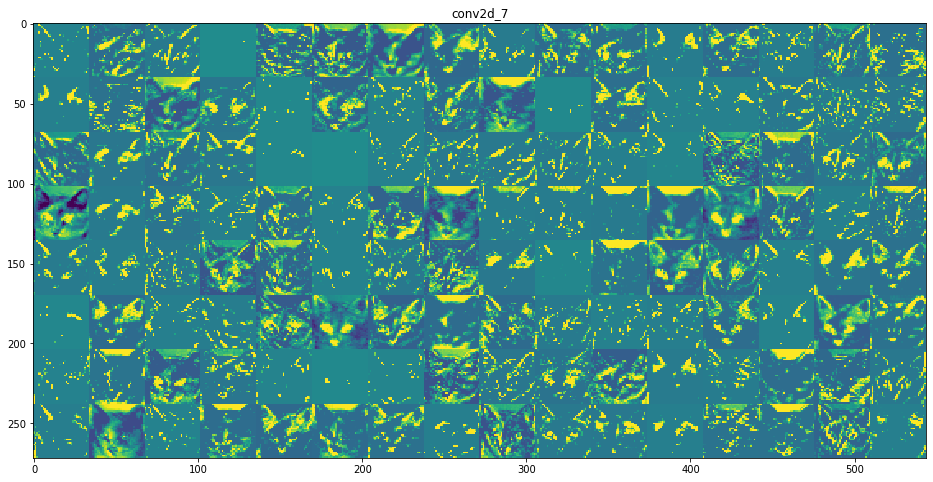

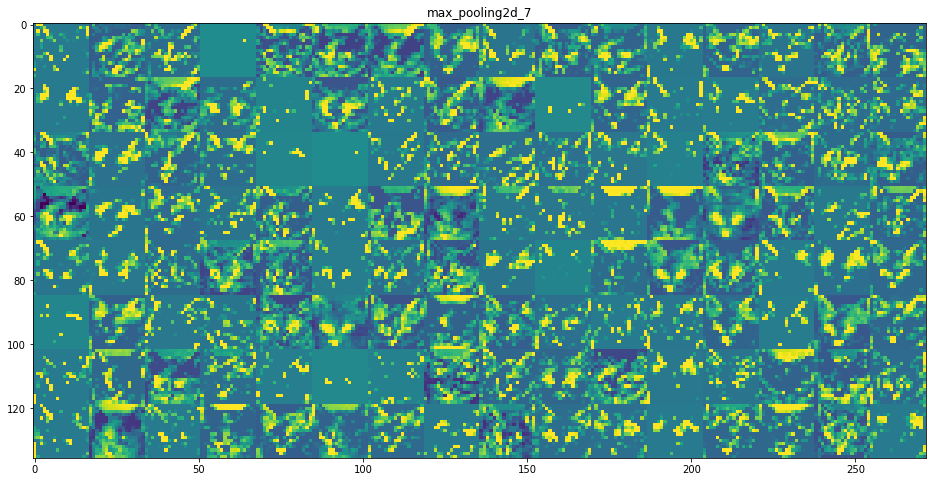

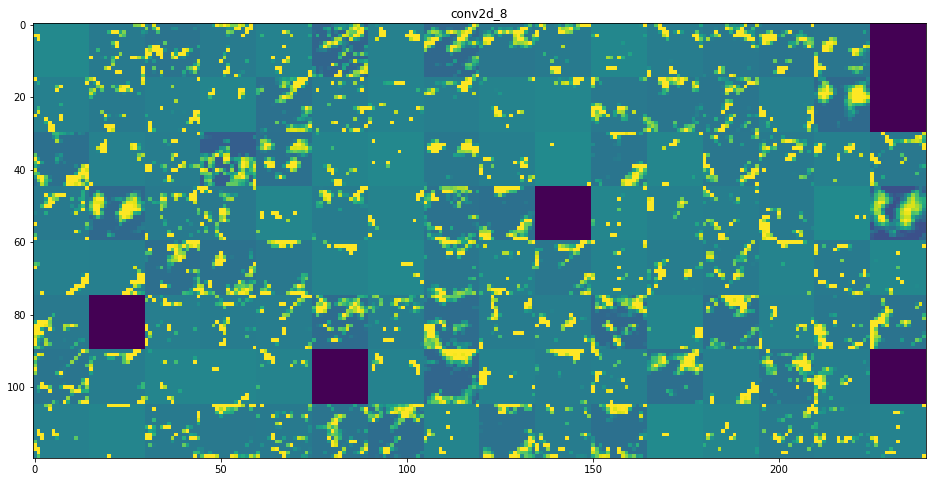

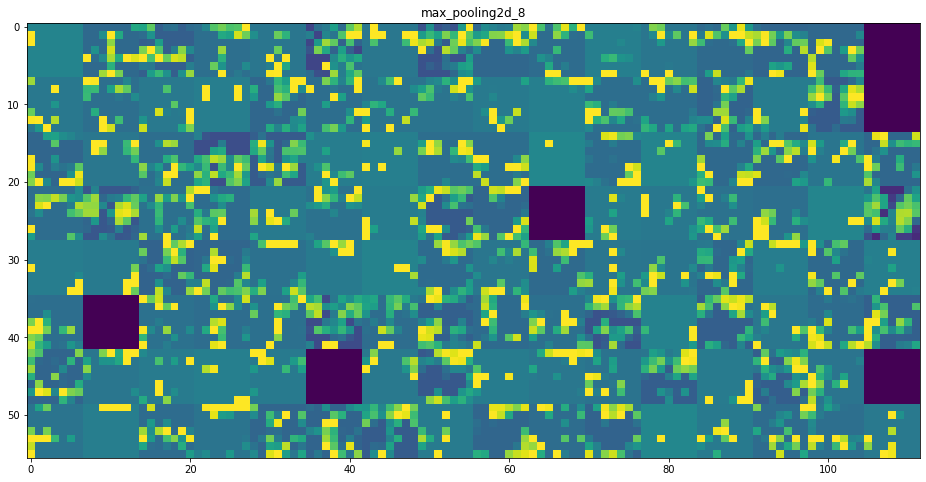

In [22]:
layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)
    

rows = 16

for name, activation in zip(layer_names, activations):
    n_channels = activation.shape[-1] # number of channels 
    w_channel = activation.shape[1]   # channel's width
    h_channel = activation.shape[2]   # channel's height
    
    cols = n_channels // rows
    display_grid = np.zeros((h_channel * cols, w_channel*rows))
    
    for col in range(cols):
        for row in range(rows):
            channel = activation[0, :, :, row + rows*col]
            
            # z-score
            channel_mean = channel.mean()
            channel_std = channel.std()
            channel -= channel_mean
            channel /= channel_std
            
            # 오른쪽으로 2만큼 이동 후 64 곱해서 0~255로 증폭
            channel += 2
            channel *= 64
            
            # 0~255로 cliping
            channel = np.clip(channel, 0, 255).astype('uint8')
            
            display_grid[col*h_channel : (col+1)*h_channel,
                         row*w_channel : (row+1)*w_channel] = channel
            
        
    scale = 1./w_channel
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### 표준정규분포에서 95%의 데이터만 증폭시키기 (위 코드의 20~29번째 line)

#### line 20~25
- z-score로 변환 $z = \frac{x - \mu}{\sigma}$
- 따라서 **평균 $\mu = 0$, 표준편차 $\sigma = 1$이 됨**

#### line 26~29
- 표준정규분포에서 95%는 표준점수 -1.96\~1.96 구간이므로 약 **-2\~2구간의 데이터**

<img src="./images/data_95percent.png" alt="data_95percent" style="zoom: 50%" align="left" />

- **위 구간(-2, 2) 데이터의 최솟값과 최댓값을 구하고 그 데이터만 0~255로 증폭시켜야 함**


- **-2 지점에서의 최소값 데이터**
    - $z = \frac{x - \mu}{\sigma}$
    - 위 식을 x에 대해 정리하면, 다음과 같다.
    - $x = z \sigma + \mu$에서, 평균 $\mu = 0$, 표준편차 $\sigma = 1$, 표준점수 $z = -2$
    - $\therefore x = -2$
    - **따라서 위 구간 데이터의 최솟값은 -2이다** 
    
    
- **2 지점에서의 최소값 데이터**
    - $z = \frac{x - \mu}{\sigma}$
    - 위 식을 x에 대해 정리하면, 다음과 같다.
    - $x = z \sigma + \mu$에서, 평균 $\mu = 0$, 표준편차 $\sigma = 1$, 표준점수 $z = 2$
    - $\therefore x = 2$
    - **따라서 위 구간 데이터의 최댓값은 2이다**
    

#### 따라서 데이터를 오른쪽으로 2만큼 옮긴 후 전체 데이터에 64를 곱해주면 0~255의 데이터로 증폭됨

### 출력된 특성맵 이미지 분석

- 1번째 층의 출력
    - 여러 종류의 edge 감지를 모아놓은 형태
    - 이 단계에서는 초기 사진에 있는 거의 모든 정보가 유지됨
    

- 상위 층의 출력
    - 상위층으로 갈수록 출력은 점점 더 추상화되어 시각적으로 이해하기 어려워짐(고수준의 개념을 인코딩 함)
    - 이미지의 시각적 콘텐츠에 관한 정보가 줄어들고 클래스에 관한 정보가 점점 증가
    
    
- 비어있는 출력
    - 층이 깊어짐에 따라 비어있는 출력이 늘어남
    - 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않음을 의미
    
    
### 정리
- **특성은 층의 깊이가 깊어짐에 따라 점점 더 추상화됨**
- **높은 층의 출력(활성화)는 특정 입력에 관한 시각적 정보가 점점 줄어들고 타깃에 관한 정보가 점점 더 증가함**
- 심층 신경망은 입력되는 원본 데이터에 대한 반복적인 변환을 통해 관계없는 정보를 걸러내고 유용한 정보는 강조되고 개선시킴